# Lezzetli Asya ve Hint Mutfağı: Bir Sınıflandırma Modeli Oluşturun


## Mutfak sınıflandırıcıları 1

Bu derste, *bir grup malzemeye dayanarak belirli bir ulusal mutfağı tahmin etmek* için çeşitli sınıflandırıcıları keşfedeceğiz. Bunu yaparken, algoritmaların sınıflandırma görevlerinde nasıl kullanılabileceği hakkında daha fazla bilgi edineceğiz.

### [**Ders öncesi test**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Hazırlık**

Bu ders, [önceki dersimize](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb) dayanır. Önceki derste:

-   Asya ve Hindistan'ın tüm muhteşem mutfakları hakkında bir veri seti kullanarak sınıflandırmalara nazik bir giriş yaptık 😋.

-   Verilerimizi hazırlamak ve temizlemek için bazı [dplyr fiilleri](https://dplyr.tidyverse.org/) keşfettik.

-   ggplot2 kullanarak güzel görselleştirmeler yaptık.

-   [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html) kullanarak dengesiz verileri ön işleme ile nasıl ele alacağımızı gösterdik.

-   Tarifimizi `prep` ve `bake` ederek, beklenildiği gibi çalışacağından emin olmayı gösterdik.

#### **Ön Koşul**

Bu ders için, verilerimizi temizlemek, hazırlamak ve görselleştirmek için aşağıdaki paketlere ihtiyacımız olacak:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/), veri bilimini daha hızlı, kolay ve eğlenceli hale getirmek için tasarlanmış bir [R paketleri koleksiyonudur](https://www.tidyverse.org/packages).

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) çerçevesi, modelleme ve makine öğrenimi için bir [paketler koleksiyonudur](https://www.tidymodels.org/packages/).

-   `themis`: [themis paketi](https://themis.tidymodels.org/), dengesiz verilerle başa çıkmak için ekstra tarif adımları sağlar.

-   `nnet`: [nnet paketi](https://cran.r-project.org/web/packages/nnet/nnet.pdf), tek bir gizli katmanlı ileri beslemeli sinir ağlarını ve çoklu lojistik regresyon modellerini tahmin etmek için işlevler sağlar.

Bu paketleri şu şekilde yükleyebilirsiniz:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Alternatif olarak, aşağıdaki betik bu modülü tamamlamak için gerekli paketlere sahip olup olmadığınızı kontrol eder ve eksikse sizin için yükler.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



Haydi başlayalım!

## 1. Veriyi eğitim ve test setlerine ayırın.

Önceki dersimizden birkaç adımı seçerek başlayacağız.

### Farklı mutfaklar arasında karışıklığa neden olan en yaygın malzemeleri `dplyr::select()` kullanarak çıkarın.

Herkes pirinci, sarımsağı ve zencefili sever!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Harika! Şimdi verileri %70'i eğitim ve %30'u test olacak şekilde bölelim. Ayrıca, verileri bölerken `stratifikasyon` tekniğini uygulayarak `her bir mutfağın oranını` eğitim ve doğrulama veri setlerinde koruyacağız.

[rsample](https://rsample.tidymodels.org/), Tidymodels içinde verimli veri bölme ve yeniden örnekleme için altyapı sağlar:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Dengesiz Verilerle Başa Çıkmak

Orijinal veri setinde ve eğitim setimizde fark etmiş olabileceğiniz gibi, mutfakların sayısında oldukça eşitsiz bir dağılım var. Kore mutfakları, *neredeyse* Tay mutfaklarının 3 katı kadar. Dengesiz veriler genellikle model performansı üzerinde olumsuz etkiler yaratır. Birçok model, gözlem sayısı eşit olduğunda en iyi performansı gösterir ve bu nedenle dengesiz verilerle mücadele etmekte zorlanır.

Dengesiz veri setleriyle başa çıkmanın iki ana yolu vardır:

-   azınlık sınıfına gözlem eklemek: `Over-sampling` örneğin, SMOTE algoritması kullanarak azınlık sınıfının yeni örneklerini bu vakaların en yakın komşularını kullanarak sentetik olarak oluşturmak.

-   çoğunluk sınıfından gözlem çıkarmak: `Under-sampling`

Önceki dersimizde, dengesiz veri setleriyle nasıl başa çıkılacağını bir `recipe` kullanarak göstermiştik. Recipe, bir veri setine veri analizi için hazır hale getirmek amacıyla hangi adımların uygulanması gerektiğini açıklayan bir taslak olarak düşünülebilir. Bizim durumumuzda, `eğitim setimiz` için mutfaklarımızın sayısında eşit bir dağılım elde etmek istiyoruz. Hadi başlayalım.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Tarifi beklendiği gibi çalışacağından emin olmak için (hazırlık + pişirme kullanarak) kontrol edebilirsiniz - tüm mutfak etiketlerinin `559` gözlemi olduğunu göreceksiniz.

Bu tarifi modelleme için bir ön işleyici olarak kullanacağımızdan, bir `workflow()` bizim için tüm hazırlık ve pişirme işlemlerini gerçekleştirecek, böylece tarifi manuel olarak tahmin etmemize gerek kalmayacak.

Şimdi bir model eğitmeye hazırız 👩‍💻👨‍💻!

## 3. Sınıflandırıcınızı Seçmek

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>@allison_horst tarafından yapılmış bir illüstrasyon</figcaption>


Şimdi hangi algoritmayı kullanacağımıza karar vermeliyiz 🤔.

Tidymodels'de, [`parsnip paketi`](https://parsnip.tidymodels.org/index.html), farklı motorlar (paketler) arasında modellerle çalışmak için tutarlı bir arayüz sağlar. [Model türleri ve motorları](https://www.tidymodels.org/find/parsnip/#models) ile ilgili belgeleri ve bunlara karşılık gelen [model argümanlarını](https://www.tidymodels.org/find/parsnip/#model-args) incelemek için parsnip belgelerine göz atabilirsiniz. Çeşitlilik ilk bakışta oldukça kafa karıştırıcı olabilir. Örneğin, aşağıdaki yöntemlerin tümü sınıflandırma tekniklerini içerir:

-   C5.0 Kural Tabanlı Sınıflandırma Modelleri

-   Esnek Ayrımcı Modeller

-   Doğrusal Ayrımcı Modeller

-   Düzenlenmiş Ayrımcı Modeller

-   Lojistik Regresyon Modelleri

-   Multinom Regresyon Modelleri

-   Naive Bayes Modelleri

-   Destek Vektör Makineleri

-   En Yakın Komşular

-   Karar Ağaçları

-   Toplu Yöntemler

-   Sinir Ağları

Liste uzayıp gidiyor!

### **Hangi sınıflandırıcıyı seçmeli?**

Peki, hangi sınıflandırıcıyı seçmelisiniz? Çoğu zaman, birkaçını denemek ve iyi bir sonuç aramak test etmenin bir yoludur.

> AutoML, bu karşılaştırmaları bulutta çalıştırarak, verileriniz için en iyi algoritmayı seçmenize olanak tanıyarak bu sorunu kolayca çözer. [Buradan](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott) deneyin.

Ayrıca sınıflandırıcı seçimi problemimize bağlıdır. Örneğin, sonuç `iki sınıftan daha fazla` kategorize edilebiliyorsa, bizim durumumuzda olduğu gibi, `ikili sınıflandırma` yerine `çok sınıflı sınıflandırma algoritması` kullanmanız gerekir.

### **Daha iyi bir yaklaşım**

Ancak rastgele tahmin etmekten daha iyi bir yol, bu indirilebilir [ML Cheat Sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott) üzerindeki fikirleri takip etmektir. Burada, çok sınıflı problemimiz için bazı seçeneklerimiz olduğunu keşfediyoruz:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Microsoft'un Algoritma Cheat Sheet'inin bir bölümü, çok sınıflı sınıflandırma seçeneklerini detaylandırıyor</figcaption>


### **Mantık**

Elimizdeki kısıtlamalar göz önüne alındığında farklı yaklaşımları değerlendirelim:

-   **Derin sinir ağları çok ağır**. Temiz ama minimal bir veri setimiz olduğu ve eğitim işlemini yerel olarak notebooklar üzerinden gerçekleştirdiğimiz için, derin sinir ağları bu görev için fazla ağır kalıyor.

-   **İki sınıflı sınıflandırıcı yok**. İki sınıflı bir sınıflandırıcı kullanmıyoruz, bu nedenle one-vs-all (birine karşı tümü) yöntemi devre dışı kalıyor.

-   **Karar ağacı veya lojistik regresyon işe yarayabilir**. Karar ağacı veya çok sınıflı lojistik regresyon/multinomial regresyon çok sınıflı veri için işe yarayabilir.

-   **Çok sınıflı Boosted Karar Ağaçları farklı bir problemi çözüyor**. Çok sınıflı boosted karar ağacı, sıralama oluşturma gibi parametrik olmayan görevler için en uygun olanıdır, bu nedenle bizim için kullanışlı değil.

Ayrıca, genellikle daha karmaşık makine öğrenimi modellerine (örneğin ensemble yöntemleri) geçmeden önce, en basit modeli oluşturmak ve neler olup bittiğini anlamak iyi bir fikirdir. Bu ders için, `multinomial regression` modeliyle başlayacağız.

> Lojistik regresyon, sonuç değişkeni kategorik (veya nominal) olduğunda kullanılan bir tekniktir. İkili lojistik regresyonda sonuç değişkeni sayısı iki iken, multinomial lojistik regresyonda sonuç değişkeni sayısı ikiden fazladır. Daha fazla bilgi için [İleri Regresyon Yöntemleri](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) bağlantısına bakabilirsiniz.

## 4. Multinomial lojistik regresyon modelini eğitmek ve değerlendirmek.

Tidymodels'de, `parsnip::multinom_reg()`, multinomial dağılımı kullanarak çok sınıflı veriyi tahmin etmek için doğrusal tahminciler kullanan bir modeli tanımlar. Bu modeli fit etmek için kullanabileceğiniz farklı yollar/motorlar hakkında bilgi almak için `?multinom_reg()`'e bakabilirsiniz.

Bu örnek için, varsayılan [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) motoru üzerinden bir Multinomial regresyon modeli fit edeceğiz.

> `penalty` değerini rastgele seçtim. Bu değeri seçmek için daha iyi yöntemler var, örneğin `resampling` ve modeli `tuning` yaparak, ki bunu daha sonra tartışacağız.
>
> Model hiperparametrelerini nasıl ayarlayacağınızı öğrenmek isterseniz [Tidymodels: Başlangıç](https://www.tidymodels.org/start/tuning/) bağlantısına göz atabilirsiniz.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Harika iş çıkardınız 🥳! Artık bir tarifimiz ve bir model spesifikasyonumuz olduğuna göre, bunları bir araya getirip önce veriyi ön işleyen, ardından ön işlenmiş veri üzerinde modeli eğiten ve potansiyel olarak son işlem aktivitelerine de olanak tanıyan bir nesneye dönüştürmenin bir yolunu bulmamız gerekiyor. Tidymodels'de, bu kullanışlı nesne [`workflow`](https://workflows.tidymodels.org/) olarak adlandırılır ve modelleme bileşenlerinizi pratik bir şekilde bir arada tutar! Python'da buna *pipelines* derdik.

Şimdi her şeyi bir workflow içinde bir araya getirelim!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


İş akışları 👌👌! Bir **`workflow()`** tıpkı bir model gibi uyarlanabilir. Öyleyse, bir model eğitme zamanı!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Modelin eğitim sırasında öğrendiği katsayılar çıktı olarak gösterilir.

### Eğitilmiş Modeli Değerlendirme

Modelin nasıl bir performans sergilediğini görmek zamanı geldi 📏! Bunu bir test seti üzerinde değerlendirerek yapacağız. Hadi, test seti üzerinde tahminler yaparak başlayalım.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Harika iş! Tidymodels'de, model performansını değerlendirmek [yardstick](https://yardstick.tidymodels.org/) kullanılarak yapılabilir - performans metrikleri kullanarak modellerin etkinliğini ölçmek için kullanılan bir paket. Lojistik regresyon dersimizde yaptığımız gibi, bir karmaşıklık matrisi hesaplayarak başlayalım.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Birden fazla sınıfla uğraşırken, bunu bir ısı haritası olarak görselleştirmek genellikle daha sezgiseldir, şöyle:


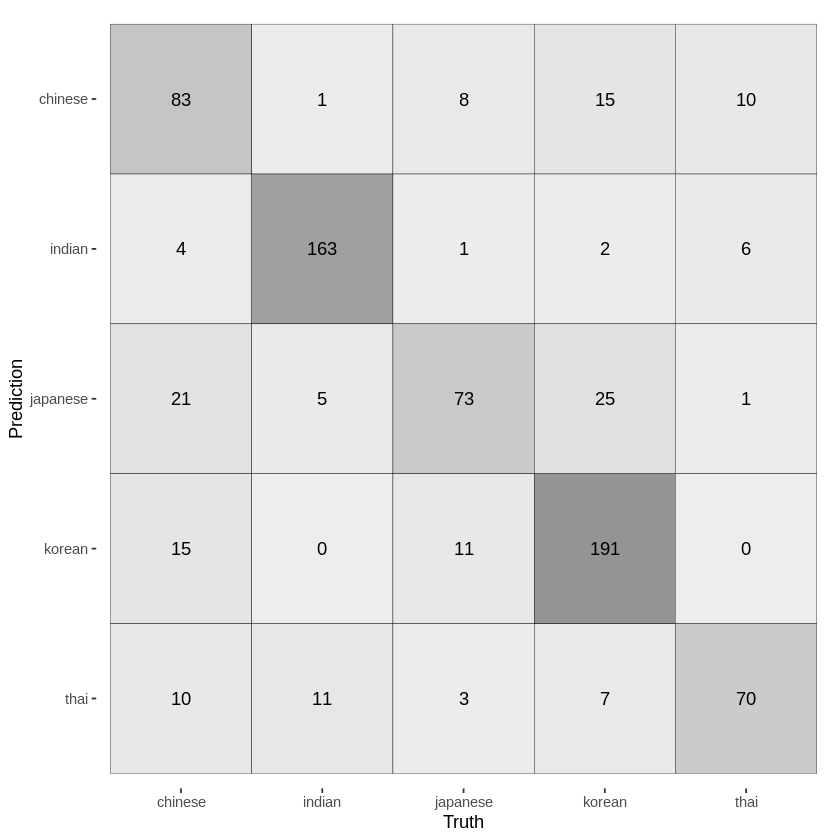

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Karmaşıklık matrisi grafiğindeki daha koyu kareler, yüksek vaka sayılarını gösterir ve umarım tahmin edilen ve gerçek etiketin aynı olduğu durumları gösteren koyu karelerden oluşan bir diyagonal çizgi görebilirsiniz.

Şimdi karmaşıklık matrisi için özet istatistikleri hesaplayalım.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Eğer doğruluk, duyarlılık, ppv gibi bazı metriklere odaklanırsak, başlangıç için fena değiliz 🥳!

## 4. Daha Derine İnmek

Hadi ince bir soru soralım: Tahmin edilen sonuç olarak belirli bir mutfak türüne karar vermek için hangi kriterler kullanılıyor?

Aslında, lojistik regresyon gibi istatistiksel makine öğrenimi algoritmaları `olasılık` temellidir; yani bir sınıflandırıcı tarafından tahmin edilen şey, olası sonuçlar kümesi üzerinde bir olasılık dağılımıdır. En yüksek olasılığa sahip sınıf, verilen gözlemler için en olası sonuç olarak seçilir.

Hadi bunu hem kesin sınıf tahminleri hem de olasılıklarla uygulayarak görelim.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

Çok daha iyi!

✅ Modelin neden ilk gözlemin Tayland mutfağı olduğundan oldukça emin olduğunu açıklayabilir misiniz?

## **🚀Meydan Okuma**

Bu derste, temizlenmiş verilerinizi kullanarak bir dizi malzemeye dayanarak ulusal bir mutfağı tahmin edebilen bir makine öğrenimi modeli oluşturdunuz. Tidymodels'in verileri sınıflandırmak için sunduğu [birçok seçeneği](https://www.tidymodels.org/find/parsnip/#models) ve multinomial regresyonu uyarlamak için [diğer yolları](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) incelemek için biraz zaman ayırın.

#### TEŞEKKÜRLER:

[`Allison Horst`](https://twitter.com/allison_horst/) R'yi daha sıcak ve ilgi çekici hale getiren harika çizimler oluşturduğu için. Daha fazla çizimi onun [galerisinde](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM) bulabilirsiniz.

[Cassie Breviu](https://www.twitter.com/cassieview) ve [Jen Looper](https://www.twitter.com/jenlooper) bu modülün orijinal Python versiyonunu oluşturdukları için ♥️

<br>
Biraz espri eklemek isterdim ama yemek kelime oyunlarını anlamıyorum 😅.

<br>

Keyifli öğrenmeler,

[Eric](https://twitter.com/ericntay), Gold Microsoft Learn Öğrenci Elçisi.



---

**Feragatname**:  
Bu belge, AI çeviri hizmeti [Co-op Translator](https://github.com/Azure/co-op-translator) kullanılarak çevrilmiştir. Doğruluk için çaba göstersek de, otomatik çevirilerin hata veya yanlışlıklar içerebileceğini lütfen unutmayın. Belgenin orijinal dili, yetkili kaynak olarak kabul edilmelidir. Kritik bilgiler için profesyonel insan çevirisi önerilir. Bu çevirinin kullanımından kaynaklanan yanlış anlamalar veya yanlış yorumlamalar için sorumluluk kabul etmiyoruz.
